In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.io import fits
import healpy as hp

In [2]:
base_dir = '/Users/Joseph/Brookhaven/Research/data/'  #directory in which catalogs are stored


#I had to change this part to work with python 3
def da():
    return map(lambda x:x.split(),open(base_dir+'/table3.dat').readlines())
def pet():
    return map(lambda x:x.split(),open(base_dir+'/DLA_DR12_v2.dat').readlines()[2:])

In [3]:
#Granet catalog
nHi=np.array([float(x[-1]) for x in da()])
z=np.array([float(x[-2]) for x in da()])   #dla redshift
zq=np.array([float(x[7]) for x in da()])   #quasar redshift
p=np.array([float(x[-3]) for x in da()])   
pn=np.array([float(x[-4]) for x in da()])
tid=[int(x[0]) for x in da()]              #thing index

In [4]:
# Pasquier catalog
tidp=[int(x[0]) for x in pet()]             #thing index
zqp=np.array([float(x[4]) for x in pet()])  #quasar redshift
zp=np.array([float(x[9]) for x in pet()])   #dla redshift
nHip=np.array([float(x[10]) for x in pet()]) 

In [5]:
# quasar catalog
qso = fits.open("../../data/DR12Q.fits")
qso_data = qso[1].data
thing_id = qso_data['THING_ID']  #thing_id for all of the quasars
thing_id = np.array(thing_id,dtype=float)
psf_mag = qso_data['PSFMAG']
psf_mag = np.array(psf_mag,dtype=float)
z_qso = qso_data['Z_PIPE']       #using 'Z_PIPE' as redshift of quasars
z_qso = np.asarray(z_qso,dtype=float) 

psf_u = psf_mag[:,0] #psf magnitudes in u band of all quasars

In [6]:
#finding the indices of the corresponding quasars in the catalogs with the DR12 catalog

p_psf_ind = []
for i in tidp:
    ind = np.where(thing_id - i == 0.) #(can be changed to different catalog by changing the thing_id)
    p_psf_ind.append(ind[0][0])  #indices of qso within parent catalog 

p_psf_ind = np.asarray(p_psf_ind,dtype=int)



g_psf_ind = []
for i in tid:  
    ind = np.where(thing_id - i == 0.)
    g_psf_ind.append(ind[0][0]) #indices of qso within parent catalog
g_psf_ind = np.asarray(g_psf_ind,dtype=int)


p_psf_u = psf_u[p_psf_ind]
g_psf_u = psf_u[g_psf_ind]

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars


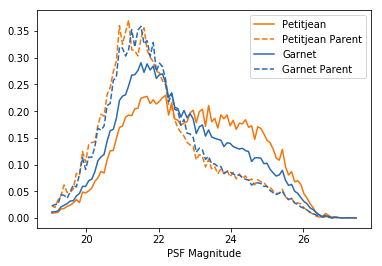

In [8]:
# Plot histogram of magnitude in the two catalogs

def m(x):                 
    return 0.5*(x[1:]+x[:-1])


#creating weighted histogram for all DR12 quasars (garnet (&pasquier?) parent)
hist_all,ed_all=np.histogram(psf_u,bins=100,range=(19,27.50),normed=True)
beg_sum = sum(hist_all)
dz=0.1
rdshift = np.arange(0, 7.2, dz)
qso_hist = np.histogram(z_qso, bins=rdshift)
dla_hist = np.histogram(z_qso[g_psf_ind], bins=rdshift)
weights = dla_hist[0]/qso_hist[0]
z_bins = (z_qso/dz).astype('int')
for i in range(len(ed_all)-1):
    ind = np.where((psf_u>ed_all[i]) * (psf_u<ed_all[i+1]))
    w_qso = weights[z_bins[ind]]
    hist_all[i] = hist_all[i]*sum(w_qso)/len(w_qso)
hist_all = np.asarray(hist_all,dtype=float)
sum_all = sum(hist_all[np.logical_not(np.isnan(hist_all))])
hist_all *= beg_sum/sum_all
#plt.plot(m(ed_all),hist_all,label='Garnet Parent',ls = '--',color='xkcd:mid blue')

#creating weighted histogram for pasquier quasars
histp,edp=np.histogram(p_psf_u,bins=100,range=(19,27.50),normed=True)
plt.plot(m(edp),histp,label='Petitjean',color='xkcd:orange')
beg_sum = sum(histp)
dz=0.1
rdshift = np.arange(0, 7.2, dz)
qso_hist = np.histogram(zqp, bins=rdshift)
dla_hist = np.histogram(zp, bins=rdshift)
weights = dla_hist[0]/qso_hist[0]
z_bins = (zqp/dz).astype('int')
for i in range(len(edp)-1):
    ind = np.where((p_psf_u>edp[i]) * (p_psf_u<edp[i+1]))
    w_qso = weights[z_bins[ind]]
    histp[i] = histp[i]*sum(w_qso)/len(w_qso)
histp = np.asarray(histp,dtype=float)
sump = sum(histp[np.logical_not(np.isnan(histp))])
histp *= beg_sum/sump
plt.plot(m(edp),histp,label='Petitjean Parent',color='xkcd:orange',ls='--')

#creating weighted histogram for garnet quasars
w=np.where(p>0.80)                 #take just p>0.8 from Granet as true DLAs, gives a right number
g_psf_uw = g_psf_u[w];
zw = z[w]; 
zqw = zq[w]
hist,ed=np.histogram(g_psf_uw,bins=100,range=(19,27.50),normed=True)
plt.plot(m(ed),hist,label='Garnet',color='xkcd:mid blue')
beg_sum = sum(hist)
dz=0.1
rdshift = np.arange(0, 7.2, dz)
qso_hist = np.histogram(zqw, bins=rdshift)
dla_hist = np.histogram(zw, bins=rdshift)
weights = dla_hist[0]/qso_hist[0]
z_bins = (zqw/dz).astype('int')
for i in range(len(ed_all)-1):
    ind = np.where((g_psf_uw>ed[i]) * (g_psf_uw<ed[i+1]))
    w_qso = weights[z_bins[ind]]
    hist[i] = hist[i]*sum(w_qso)/len(w_qso)
hist = np.asarray(hist,dtype=float)
sumg = sum(hist[np.logical_not(np.isnan(hist))])
hist *= beg_sum/sumg
plt.plot(m(ed),hist,label='Garnet Parent',color='xkcd:mid blue',ls='--')

plt.xlabel('PSF Magnitude')
plt.legend()
plt.show()